In [1]:
# import user defined function
from src.preprocessing import ut_standard_col_name
from src.model_functions import evaluate_classification, cv_bestK, evaluate_knn
from src.eda_functions import get_info
from src.viz import plot_train_test_confusion_matrix, show_cv_results, show_cv_best_accuracy_box_plot, plot_3D_class

# import standard processing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np

# import sci-kit learn methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA


# visualisation 3D
import plotly.express as px

# random seed
RANDOM_SEED = 19

# 1. Exploratory Data Analysis

In this section we are going to explore the dataset.

## 1.1 Summary information

The function `get_info()` creates a `pandas.DataFrame` with useful information for each variable in the dataset.

In particular, the result shows that there are no missing values in the input dataset. Hence, it is not necessary to impute values.

Moreover, the independent variables have different unit of measurement, thus, it is necessary to preprocess the features in order to avoid the case where the model gives more importance to a feature respect to another one due to the magnitude.

## 1.2 Duplicates

The daset does not present duplicated rows. Hence, there is no need to deel with these cases.

## 1.3 Balanced dataset

Another issue in classification problems can be due to unbalanced data in the target. Therefore, the cell below use the function `value_counts()` for the target variable `frutto` and the result shows the dataset is perfectly balanced.

In [2]:
# read data
# input_df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv")
input_df = pd.read_csv("./data/fruits.csv")

# standardise columns names
input_df = ut_standard_col_name(input_df)

# get initial information of input DataFrame
info_input_df = get_info(input_df)
display(info_input_df)

# check duplicates
print(f"The input dataset has {input_df.duplicated().sum()} duplicates.")

# check unbalanced target
display(input_df.frutto.value_counts())

,dtype,n_unique,nan_values,count,mean,std,min,25%,50%,75%,max
frutto,object,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peso_(g),float64,470,0,500.0,47.31344,26.768797,8.57,24.7975,42.380,68.0800,111.21
diametro_medio_(mm),float64,487,0,500.0,86.57310,64.293403,7.53,50.5100,70.450,88.8525,299.89
lunghezza_media_(mm),float64,373,0,500.0,5.29862,2.641993,1.15,2.6725,5.670,7.4550,11.14
durezza_buccia_(1-10),float64,349,0,500.0,7.43764,1.812548,3.07,6.1525,7.340,8.6150,13.72
dolcezza_(1-10),float64,305,0,500.0,3.59322,1.264899,1.25,2.5700,3.535,4.4650,6.95


The input dataset has 0 duplicates.


Mela       100
Banana     100
Arancia    100
Uva        100
Kiwi       100
Name: frutto, dtype: int64

## 1.4 Feature visualisation

Figure 1 shows all the possible combinations of features in order to show on multiple 2D scatter plots the how well groups of different exotic fruits are separated. In general, `Banana` and `Uva` target are well separated by almost all the combinations except for figures 1.8 and 1.10. Instead, fruits labeled as `Mela`, `Arancia`, and `Kiwi` are not separated for any combinations in 2D graph. However, figure 1.2 and 1.4 shows a possible separation between data points.

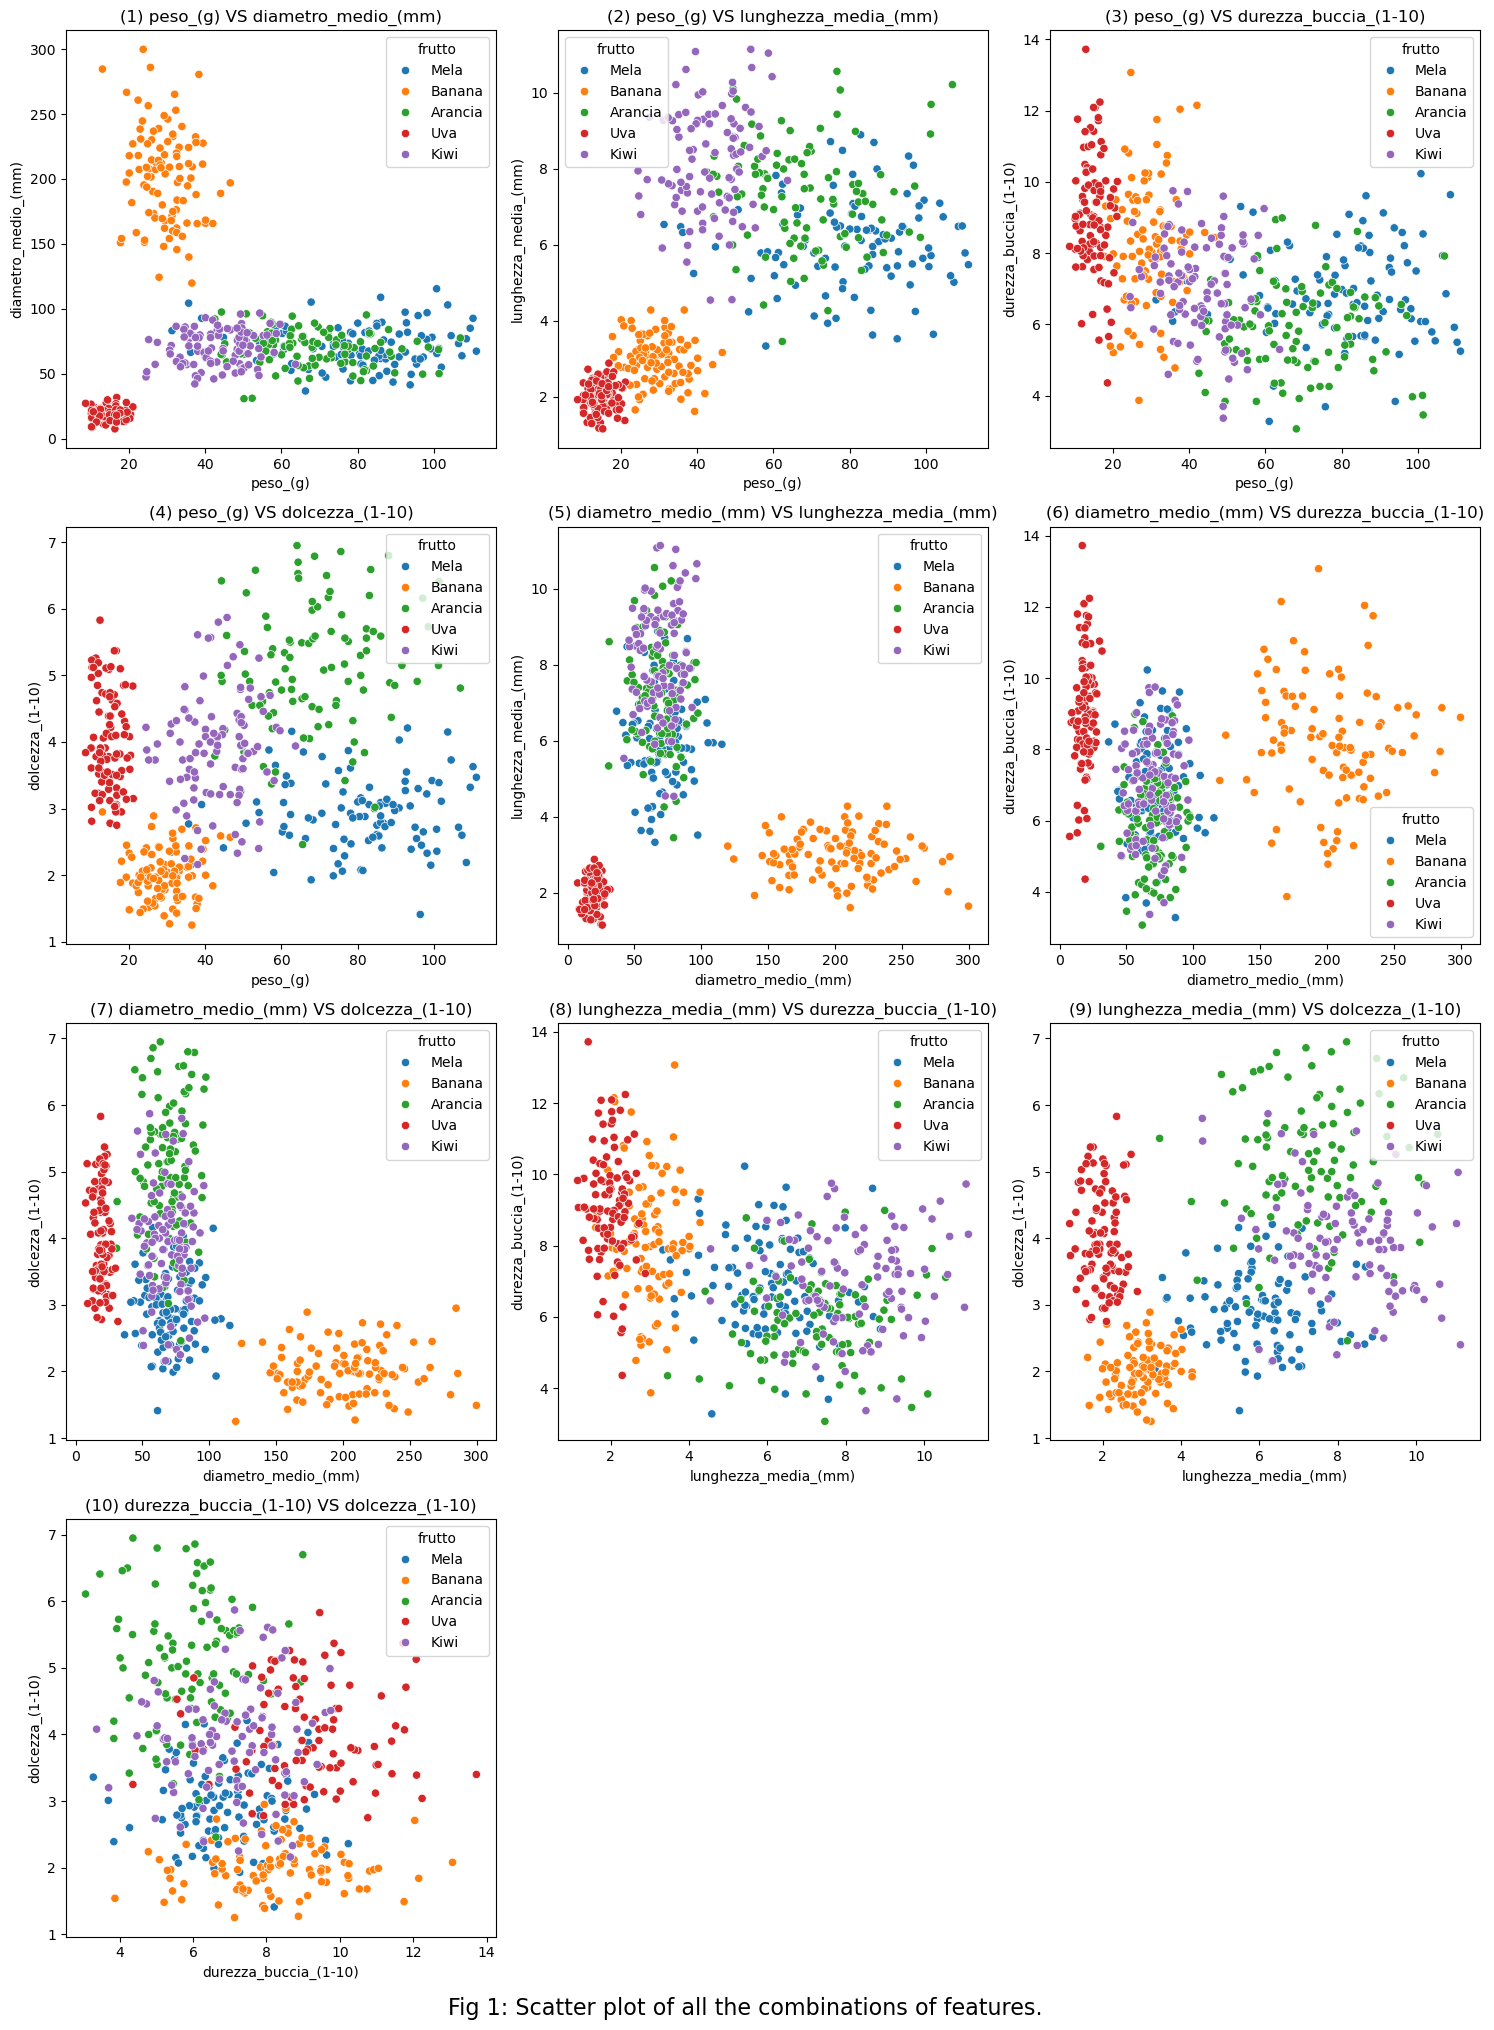

In [3]:
features_ls = list(input_df.columns)
features_ls.remove('frutto')
features_combination_ls = list(combinations(features_ls, r=2))

n_fig_per_row = 3
n_rows = int(np.ceil(len(features_combination_ls)/n_fig_per_row))

fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_fig_per_row,
                        figsize=(15, 5*n_rows),
                        tight_layout=True)

for i, ((f1, f2), ax) in enumerate(zip(features_combination_ls, axs.ravel())):
    sns.scatterplot(data=input_df, x=f1, y=f2, hue='frutto', ax=ax)
    ax.set(title=f"({i+1}) {f1} VS {f2}")

# set axis off
for ax in axs.ravel()[len(features_combination_ls):]:
    ax.set_axis_off()

fig.text(0.5, -0.01, 'Fig 1: Scatter plot of all the combinations of features.', ha='center', fontsize=16)
plt.show()

# 2 Model development

This section presents the different steps to create and validate a k-nearest neighbors (aka KNN) classfier.

The topics are:
* Preprocessing and creation of training and test set.
* Cross-Validation to find the best number of neighbours.
* Best model application.

## 2.1 Preprocessing

The KNN is a non parametric algorithm and it does not make any assumption on the distribution of the data. In the case the model does not make any assumption about the distribution is a good practice to normalize the data.

The function `MinMaxScaler()` of sci-kit learn is used to satisfy that requirement. In particular, the transformer is fitted over the training set and only applied on the test set in order to avoid a data lekeage error. The procedure creates two new variables `X_train_processed` and `X_test_processed` in order to use the raw `X_train` for the cross validation process.

Moreover, the preprocessing include also the encoding of the target variable since for sklearn is faster to train the model. However, in this example is not a necessary process since the dataset is very small.

In [4]:
# dictionary to encode target variable
fruits_dict = {
    'Arancia': 0,
    'Banana': 1,
    'Kiwi': 2,
    'Mela': 3,
    'Uva' : 4
}
# dictionary to decode target variable
fruits_dict_reversed = {v: k for k, v in fruits_dict.items()}

# get features and terget array
X = input_df.drop(columns=['frutto']).values
y = input_df.frutto.map(lambda x: fruits_dict[x]).values

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)

# normalize data
mms = MinMaxScaler()
X_train_processed = mms.fit_transform(X_train)
X_test_processed = mms.transform(X_test)

## 2.2 Cross-validation

The process of cross-validation is used to identify the best paramenter `n_neighbors` over the training set. In particular, the choice is to use a **5-fold cross validation**. Hence, the training set is divided in 5 subset and one of them is used as test set and the other as training. Moreover, the preprocessing is fitted only the fold used as training.

In [5]:
# apply cross validation
N_SPLITS = 5
metrics_cv_df = cv_bestK(dataset=(X_train, y_train),
                         Ks=np.arange(1, 45, 1),
                         preprocessor=MinMaxScaler(),
                         knn_weights='uniform',
                         n_splits=N_SPLITS,
                         rnd_seed=RANDOM_SEED,
                         all_metrics=True,
                         flag_balance_splits=False)

### 2.2.1 Results

Figure 2 shows two different graph related to accuracy (Fig 2.1) and log loss (Fig 2.2). In particular, a higher value of accuracy means a good classification of the data points, instead, a low value of the log loss means a better classificiation model. The log loss mesure the differnce between the probability to have as result a specific class and the true value for the same data point.

Figure 2.1 shows that there are three different values of number of neighbours that reach the maximum accuracy for the test sets ($n\_neighbors \in \{16, 18, 19\}$). Instead, figure 2.2 shows only a single value with the minimum value of log loss for the test sets ($n\_neighbors=16$). Hence, it seems the best value of neighbours is sixteen.

However, the results plotted corresponds only to the average value of accuracy and log loss for the 5-fold cross validation. It is possible that the value of $n\_neighbors=16$ have a high accuracy only when the fold number 1 is used as test and in the other case the value is lower. Figure 3 investigates that aspect, in particular, it shows the box plot of accuracy for the best average value of `n_neighbors`. It is possible to see that the case with $n\_neighbors=19$ have a lower variability. To decide which is the best model, it is possible to test both after the train them over the whole training set and evaluate the performances on the test set.

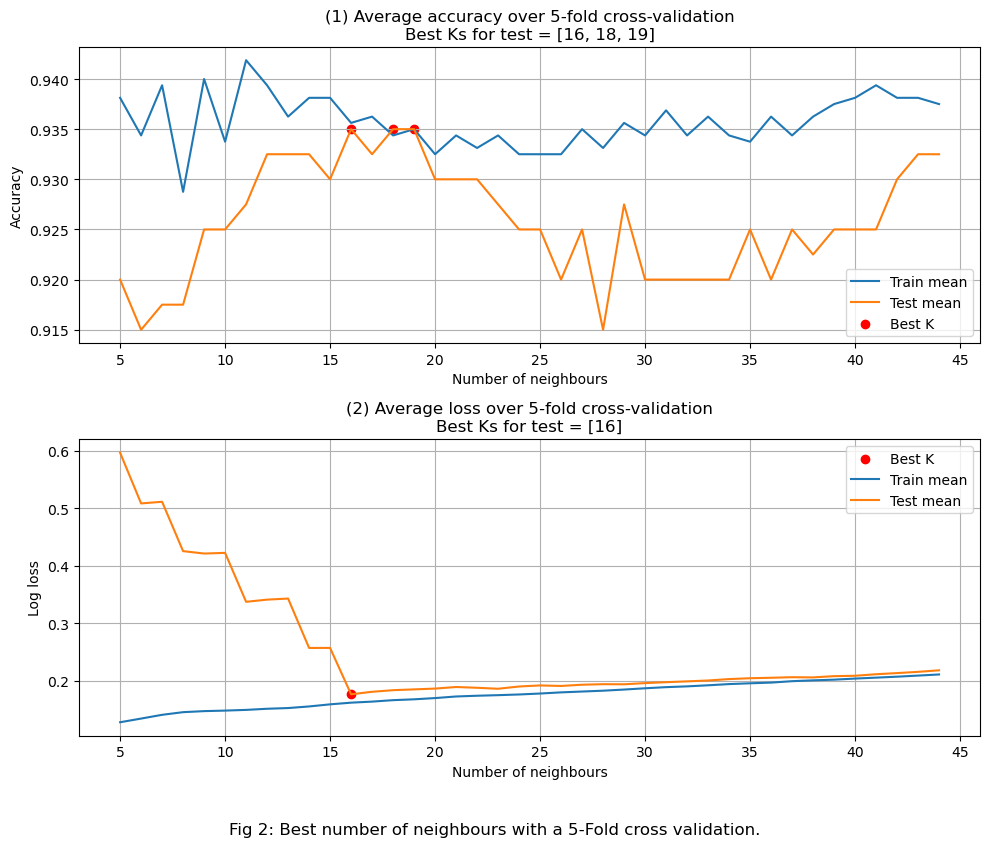

In [6]:
show_cv_results(metrics_cv_df=metrics_cv_df,
                min_neighbors=5,
                n_splits=N_SPLITS,
                fig_number=2)

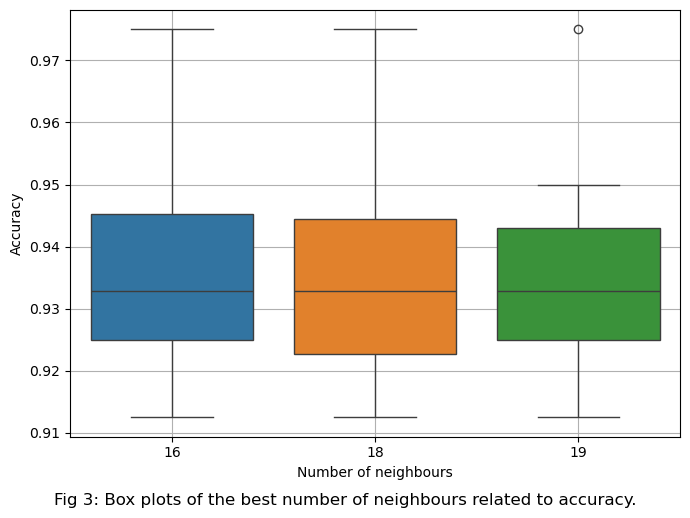

In [7]:
show_cv_best_accuracy_box_plot(metrics_cv_df=metrics_cv_df,
                               min_neighbors=5,
                               fig_number=3)

## 2.3 Final model

Section 2.2 presents the cross-validation process over the training set and evaluate the perfomrmances of multiple models. However, the performances presented are related to what the model is able to learn with a portion of the training set. Hence, it is necessary to test the possible best solution over the whole training set and the test set.

The results on the cell below presents an higher accuracy for the model with $n\_neighbors=19$ and a loss that is a bit higher. Due to those results we decide that is the best model.

In [8]:
knn_16 = evaluate_knn(n_neighbors=16,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))

knn_19 = evaluate_knn(n_neighbors=19,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))


Number of neighbours: 16
 	TRAINING:
	- accuracy: 93.25%
 	- loss: 0.1583
 	TEST:
	- accuracy: 90.00%
 	- loss: 0.1922

Number of neighbours: 19
 	TRAINING:
	- accuracy: 94.00%
 	- loss: 0.1606
 	TEST:
	- accuracy: 91.00%
 	- loss: 0.2030


# 3. Conclusions

Figure 4.1 shows the confusion matrix of the model we chose with the training set. It shows the classes are not balanced. Moreover, the model does not make any error to predict `Uva` and `Banana`, that is true also in the test set (figure 4.2). That is due to the fact features separate very well those classes. In section 1.4, we have already discussed that.

Figure 5 shows a 3D plot of the features after apply the PCA of the training set. It is possible to see how even in the 3 dimensional space the classes `Arancia`, `Mela`, and `Kiwi` overlap.

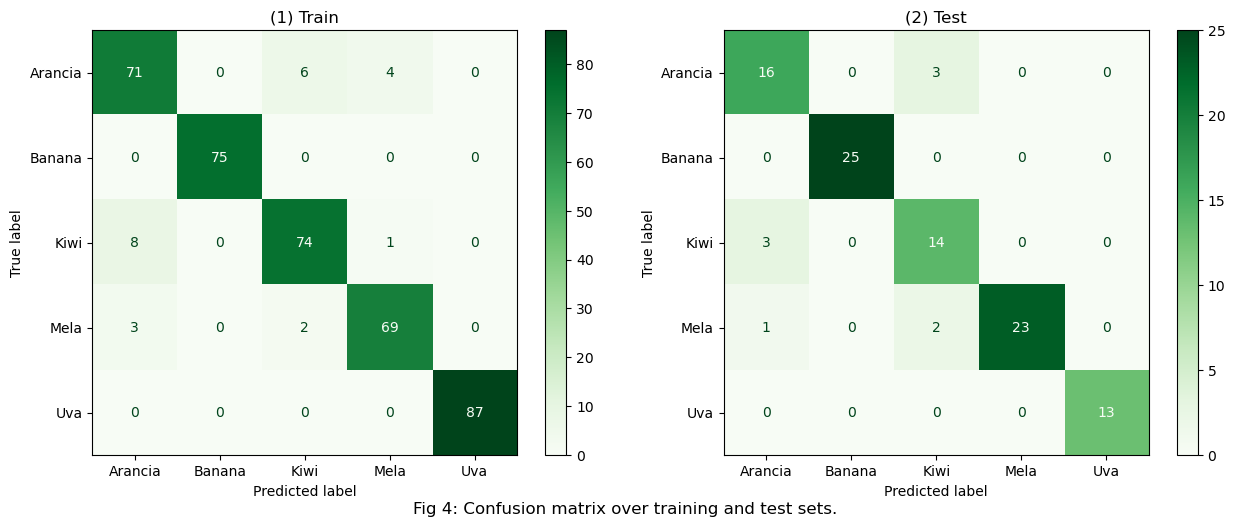

In [9]:
plot_train_test_confusion_matrix(knn_19,
                                 (X_train_processed, y_train),
                                 (X_test_processed, y_test),
                                 fig_number=4,
                                 labels=fruits_dict.keys())

In [10]:
plot_3D_class(clf_mdl=knn_19,
              dataset=(X_test_processed, y_test),
              decode_labels_dict=fruits_dict_reversed,
              flag_train=False,
              fig_number=5)

Fig 5: 3D plot of differences between predicted and true classes over the test set.


# 4. Extra

To improve the model I suggest the following methods:
1. Balance the training and test set with the parameter `stratify` in the `train_test_split` function.
2. Use the parameter `weigths='distance'` in the `KNeighboursClassifier`. That method weight points by the inverse of their distance. That is useful in case of overlapping classes such as `Mela`, `Arancia` and `Kiwi`.

## 4.1 Results

Figure 6 shows the result of classification over the entire dataset where the classes are balanced on both training and test. The KNN model gives an uniform weight to all the neighbours. In the case of $n\_neighbors \in {13, 14, 42}$ does not present overfitting and the accuracy is a bit higher respect to the best model without balancing classes in training and test sets. The model with $n\_neighbors=42$ has a too large number of neighbors so it is not considered as a best possible solution.



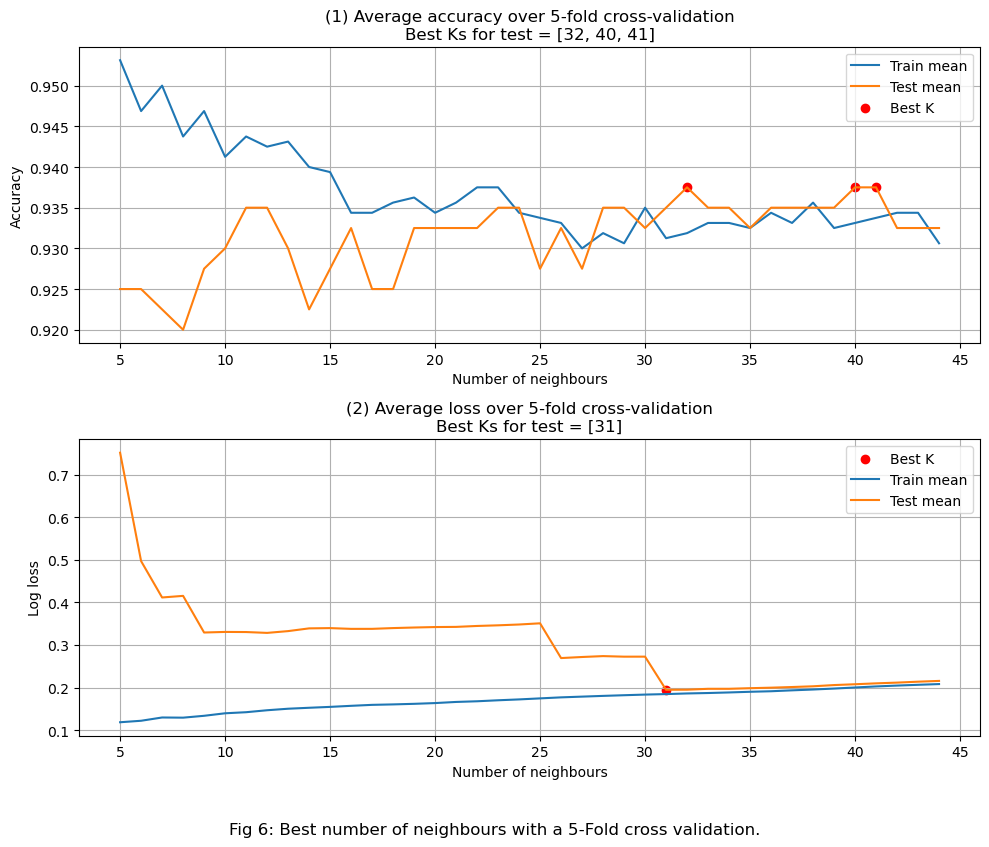

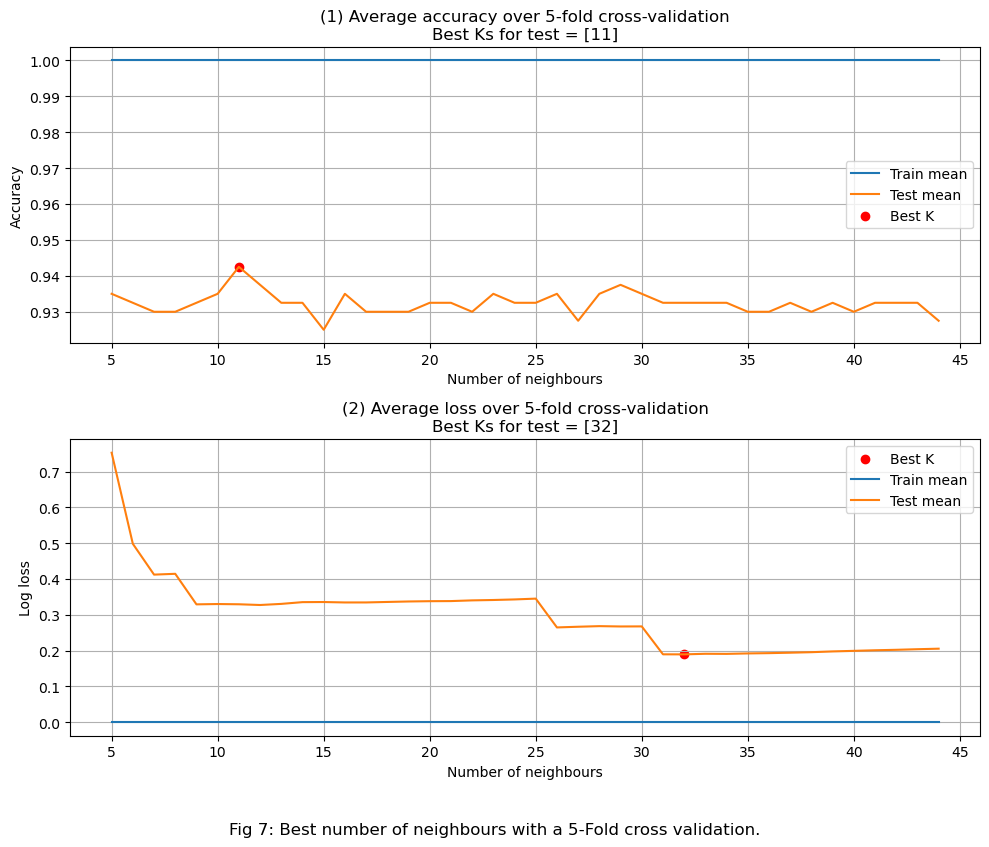

In [11]:
# split dataset into training and test set with balanced classes
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(
    X, y,
    test_size=.2,
    stratify=y,
    random_state=RANDOM_SEED)

# normalize data
mms = MinMaxScaler()
X_balanced_train_processed = mms.fit_transform(X_balanced_train)
X_balanced_test_processed = mms.transform(X_balanced_test)

metrics_balanced_cv_df = cv_bestK(
    dataset=(X_balanced_train_processed, y_balanced_train),
    Ks=np.arange(1, 45, 1),
    preprocessor=MinMaxScaler(),
    knn_weights='uniform',
    n_splits=N_SPLITS,
    rnd_seed=RANDOM_SEED,
    all_metrics=True,
    flag_balance_splits=True
)

show_cv_results(metrics_cv_df=metrics_balanced_cv_df,
                min_neighbors=5,
                n_splits=N_SPLITS,
                fig_number=6)

metrics_balanced_distance_cv_df = cv_bestK(
    dataset=(X_balanced_train_processed, y_balanced_train),
    Ks=np.arange(1, 45, 1),
    preprocessor=MinMaxScaler(),
    knn_weights='distance',
    n_splits=N_SPLITS,
    rnd_seed=RANDOM_SEED,
    all_metrics=True,
    flag_balance_splits=True
)

show_cv_results(metrics_cv_df=metrics_balanced_distance_cv_df,
                min_neighbors=5,
                n_splits=N_SPLITS,
                fig_number=7)

In [14]:
# distance weight uniform
knn_32 = evaluate_knn(n_neighbors=32,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='uniform')

knn_40 = evaluate_knn(n_neighbors=40,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='uniform')

# weight based on distance
knn_11 = evaluate_knn(n_neighbors=11,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='distance')

knn_28 = evaluate_knn(n_neighbors=28,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='distance')


Number of neighbours: 32
 	TRAINING:
	- accuracy: 93.50%
 	- loss: 0.1765
 	TEST:
	- accuracy: 93.00%
 	- loss: 0.2316

Number of neighbours: 40
 	TRAINING:
	- accuracy: 93.75%
 	- loss: 0.1860
 	TEST:
	- accuracy: 92.00%
 	- loss: 0.2419

Number of neighbours: 11
 	TRAINING:
	- accuracy: 100.00%
 	- loss: 0.0000
 	TEST:
	- accuracy: 92.00%
 	- loss: 0.1866

Number of neighbours: 28
 	TRAINING:
	- accuracy: 100.00%
 	- loss: 0.0000
 	TEST:
	- accuracy: 95.00%
 	- loss: 0.2112


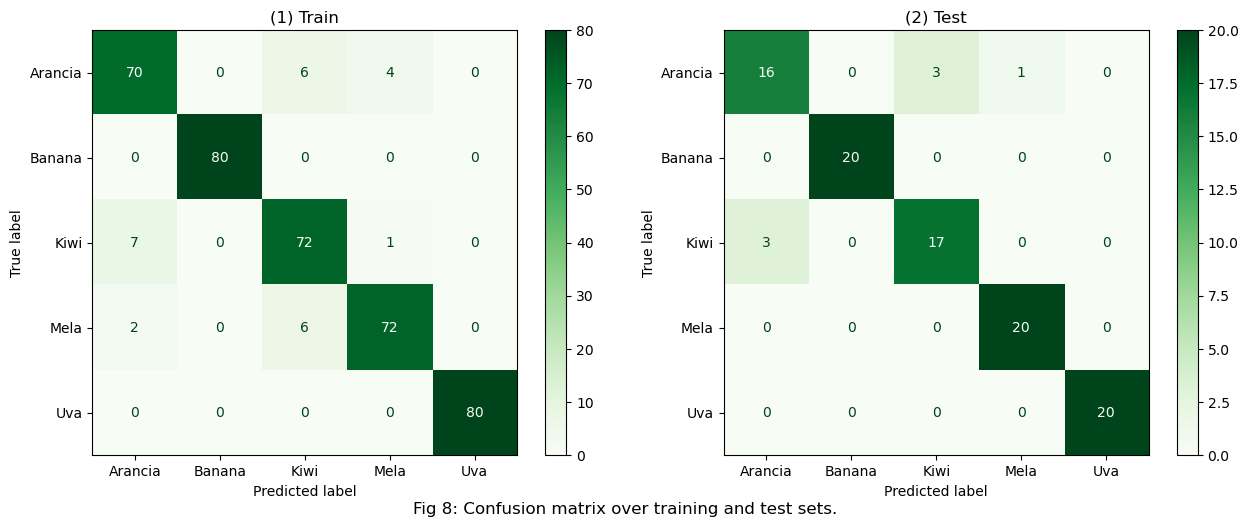

In [13]:
plot_train_test_confusion_matrix(knn_32,
                                 (X_balanced_train_processed, y_balanced_train),
                                 (X_balanced_test_processed, y_balanced_test),
                                 fig_number=8,
                                 labels=fruits_dict.keys())

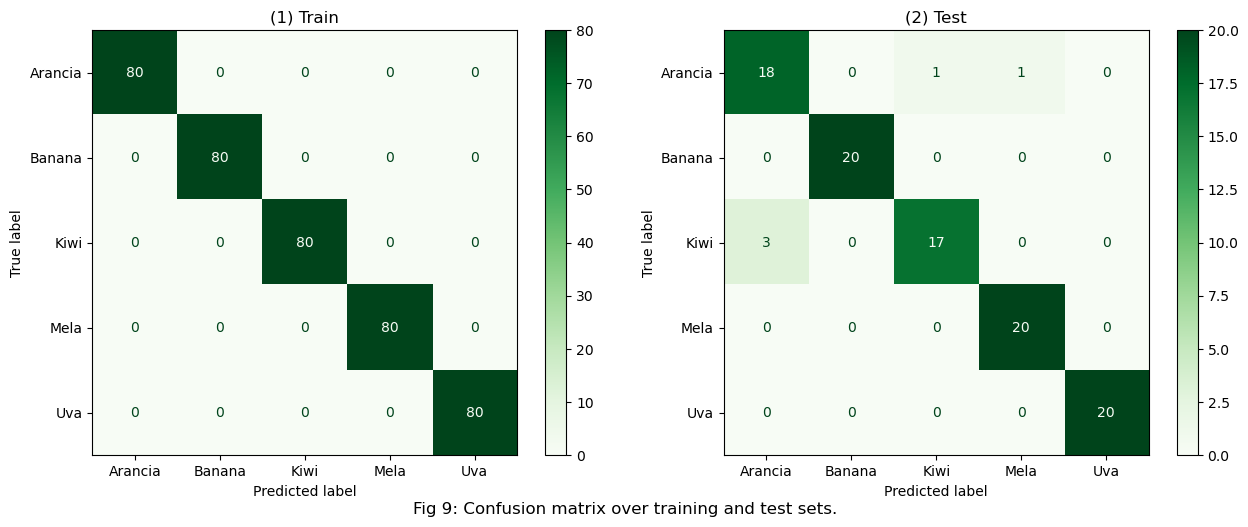

In [15]:
plot_train_test_confusion_matrix(knn_28,
                                 (X_balanced_train_processed, y_balanced_train),
                                 (X_balanced_test_processed, y_balanced_test),
                                 fig_number=9,
                                 labels=fruits_dict.keys())

In [16]:
plot_3D_class(clf_mdl=knn_28,
              dataset=(X_balanced_test_processed, y_balanced_test),
              decode_labels_dict=fruits_dict_reversed,
              flag_train=False,
              fig_number=9)

Fig 9: 3D plot of differences between predicted and true classes over the test set.
